# Chapter 6: Monte Carlo simulations in finance

## Simulating stock price dynamics using Geometric Brownian Motion

In [1]:
# importing the neccessary libraries

import warnings
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import QuantLib as ql
from chapter_6_utils import (
    simulate_gbm, 
    black_scholes_analytical, 
    lsmc_american_option
)

# Set up the plotting style and configurations
plt.style.use('seaborn')
# plt.style.use('seaborn-colorblind') # alternative
plt.rcParams['figure.figsize'] = [8, 4.5]
plt.rcParams['figure.dpi'] = 300

# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Configure Jupyter notebook for inline plotting and retina display
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

C:\Users\USER\AppData\Local\Temp\ipykernel_11960\1825815236.py:18: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


2. Define parameters for downloading data:

In [2]:
RISKY_ASSET = 'MSFT'
START_DATE = '2019-01-01'
END_DATE = '2019-07-31'

3. Download data from Yahoo Finance:

In [3]:
df = yf.download(RISKY_ASSET, start=START_DATE, 
                end=END_DATE)
print(f'Downloaded {df.shape[0]} rows of data.')

df.head()

[*********************100%%**********************]  1 of 1 completed

Downloaded 145 rows of data.


Open        High         Low       Close  Adj Close  \
Date                                                                    
2019-01-02   99.550003  101.750000   98.940002  101.120003  95.673454   
2019-01-03  100.099998  100.190002   97.199997   97.400002  92.153831   
2019-01-04   99.720001  102.510002   98.930000  101.930000  96.439835   
2019-01-07  101.639999  103.269997  100.980003  102.059998  96.562828   
2019-01-08  103.040001  103.970001  101.709999  102.800003  97.262970   

              Volume  
Date                  
2019-01-02  35329300  
2019-01-03  42579100  
2019-01-04  44060600  
2019-01-07  35656100  
2019-01-08  31514400

4. Calculate daily returns:

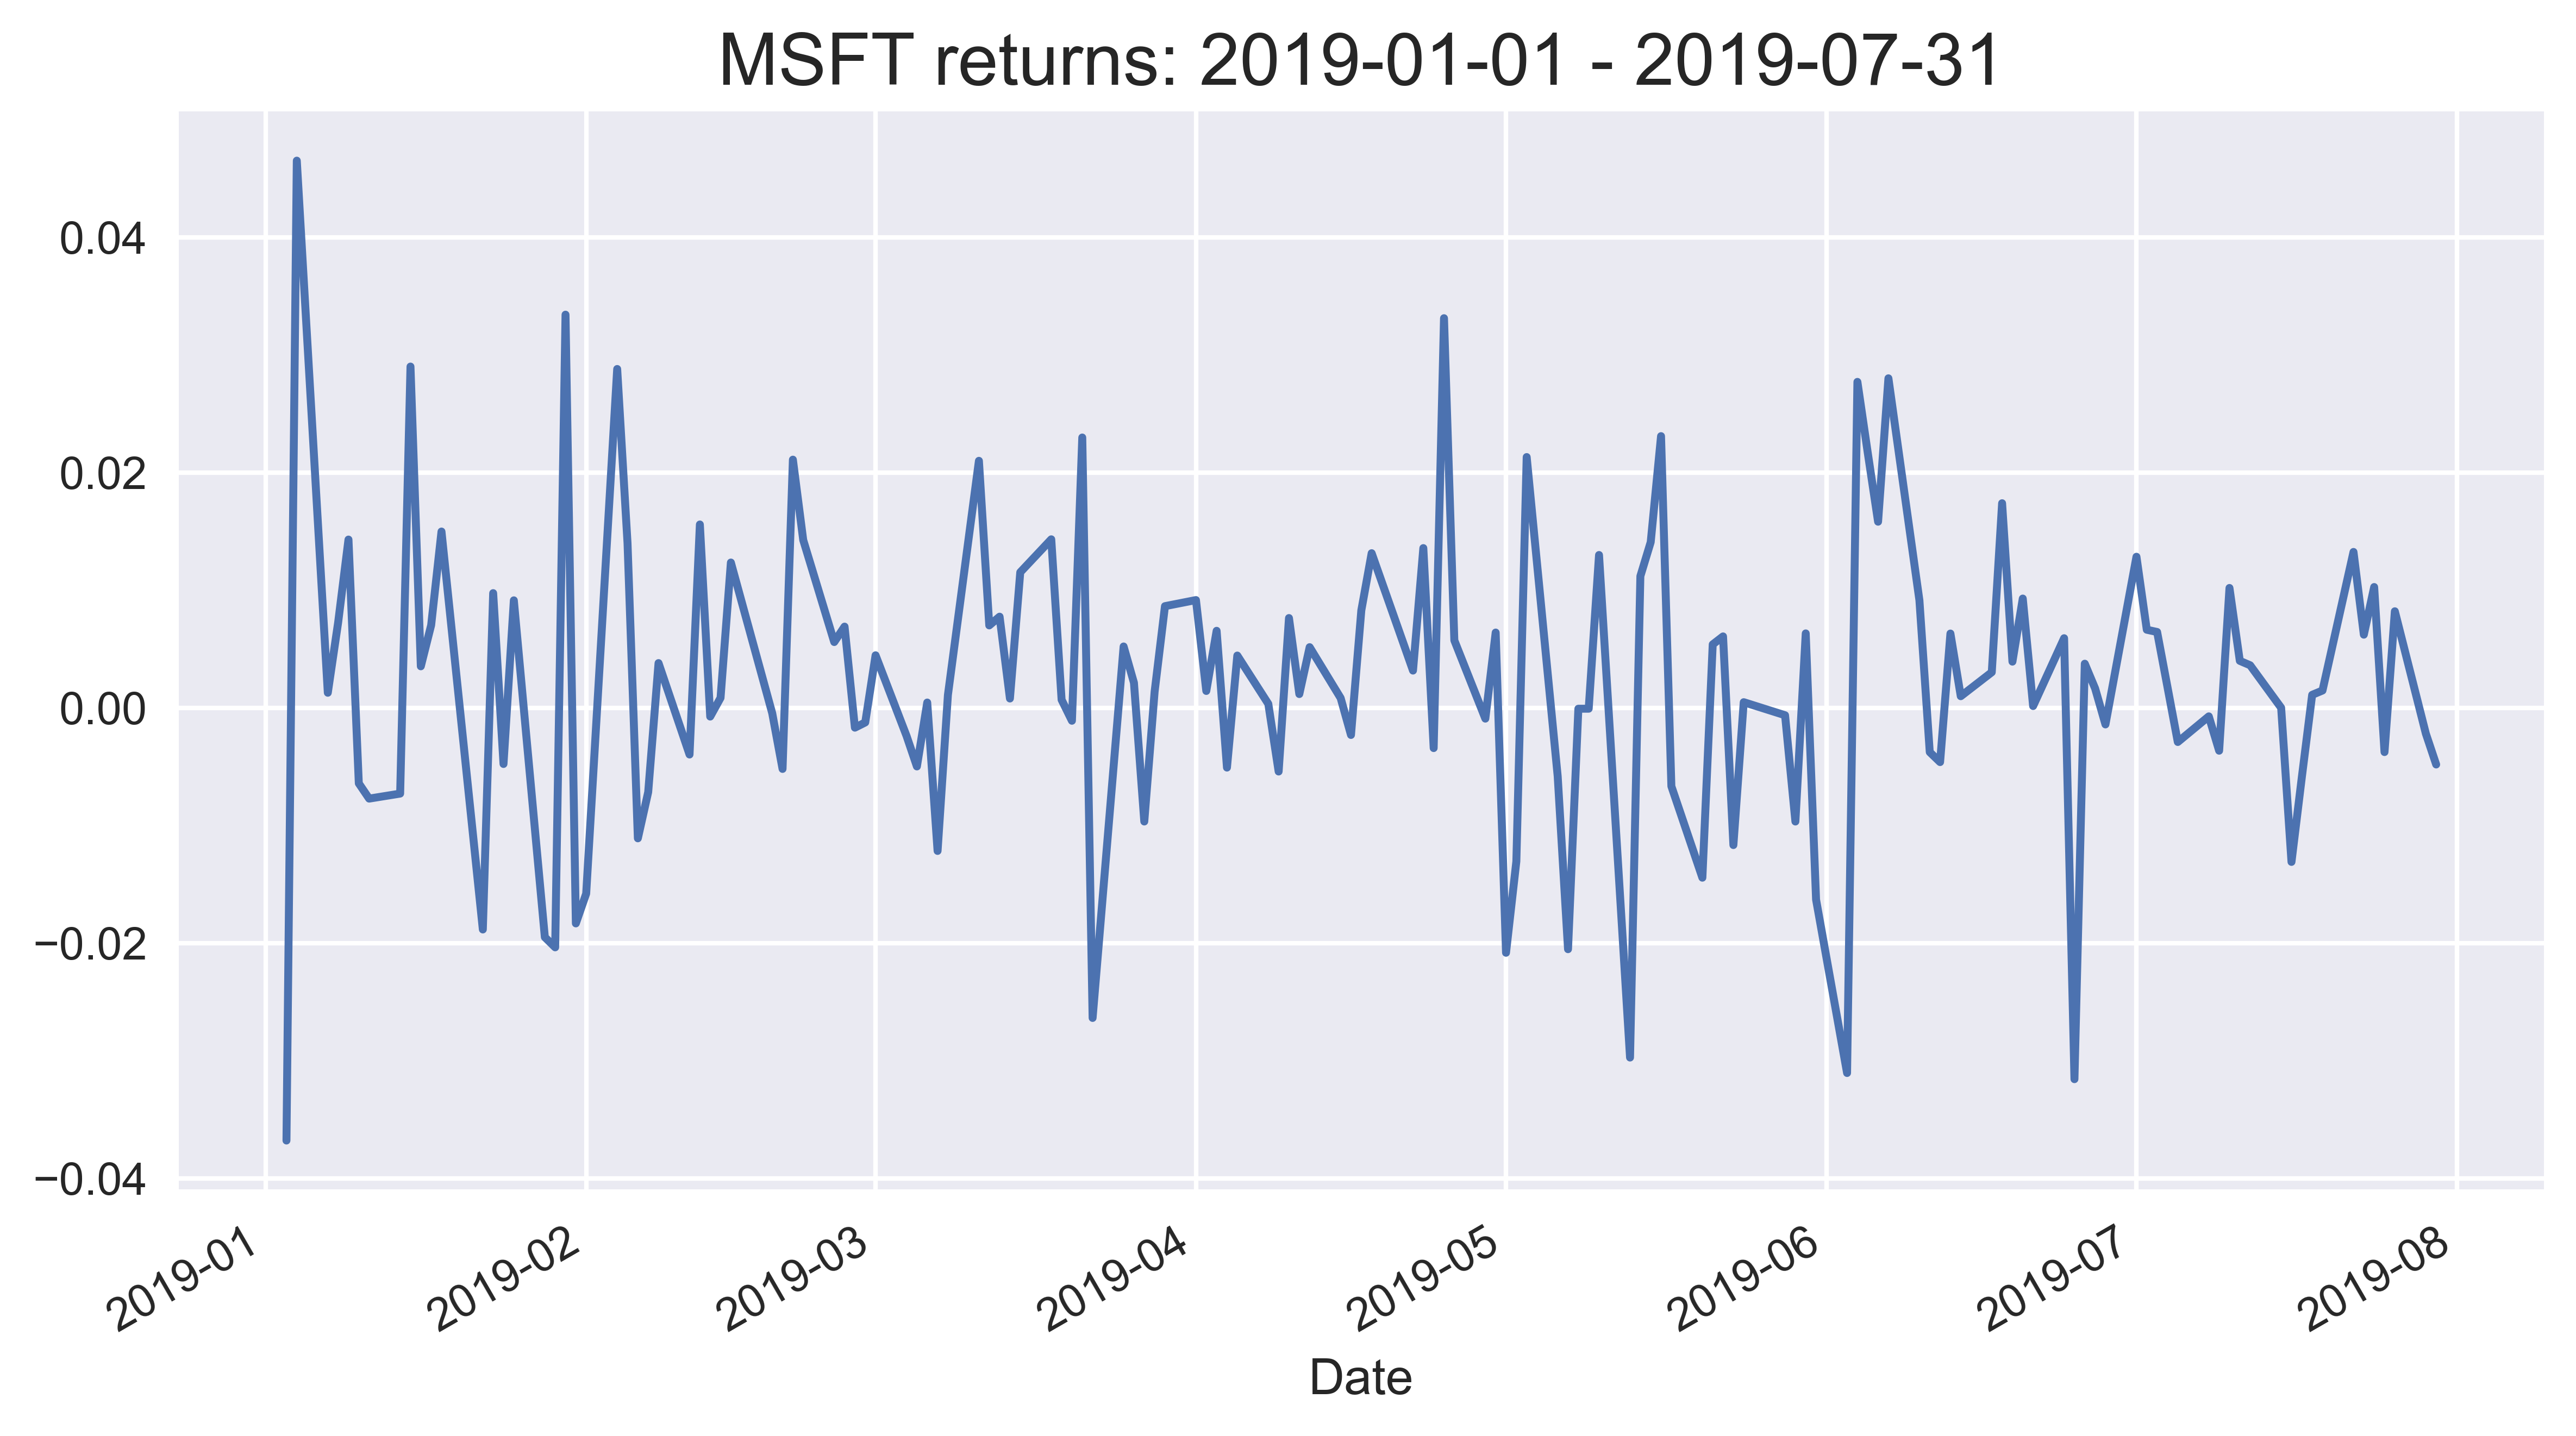

Average return: 0.24%


In [4]:
adj_close = df['Adj Close']
returns = adj_close.pct_change().dropna()

ax = returns.plot()
ax.set_title(f'{RISKY_ASSET} returns: {START_DATE} - {END_DATE}', 
             fontsize=16)

plt.tight_layout()
plt.show()

print(f'Average return: {100 * returns.mean():.2f}%')

5. Split data into the training and test sets:

In [5]:
train = returns['2019-01-01':'2019-06-30']
test = returns['2019-07-01':'2019-07-31']

6. Specify the parameters of the simulation:

In [6]:
T = len(test)
N = len(test)
s_0 = adj_close[train.index[-1]]
N_SIM = 100
mu = train.mean()
sigma = train.std()

7. Define the function used for simulations:

In [7]:
def simulate_gbm(s_0, mu, sigma, n_sims, T, N, random_seed=42):
    '''
    Function used for simulating stock returns using Geometric Brownian Motion.
    
    Parameters
    ----------
    s_0 : float
        Initial stock price.
    mu : float
        Drift coefficient.
    sigma : float
        Diffusion coefficient.
    n_sims : int
        Number of simulation paths.
    T : float
        Length of the forecast horizon, in the same unit as dt.
    N : int
        Number of time increments in the forecast horizon.
    random_seed : int, optional
        Random seed for reproducibility (default is 42).
    
    Returns
    -------
    S_t : np.ndarray
        Matrix (size: n_sims x (N+1)) containing the simulation results. 
        Rows represent sample paths, while columns represent points in time.
    '''
    np.random.seed(random_seed)
    
    dt = T / N
    dW = np.random.normal(scale=np.sqrt(dt), size=(n_sims, N))
    W = np.cumsum(dW, axis=1)
    
    time_step = np.linspace(dt, T, N)
    time_steps = np.broadcast_to(time_step, (n_sims, N))
    
    S_t = s_0 * np.exp((mu - 0.5 * sigma**2) * time_steps + sigma * W)
    S_t = np.insert(S_t, 0, s_0, axis=1)
    
    return S_t

8. Run the simulations:

In [8]:
gbm_simulations = simulate_gbm(s_0, mu, sigma, N_SIM, T, N)

9. Plot simulation results:

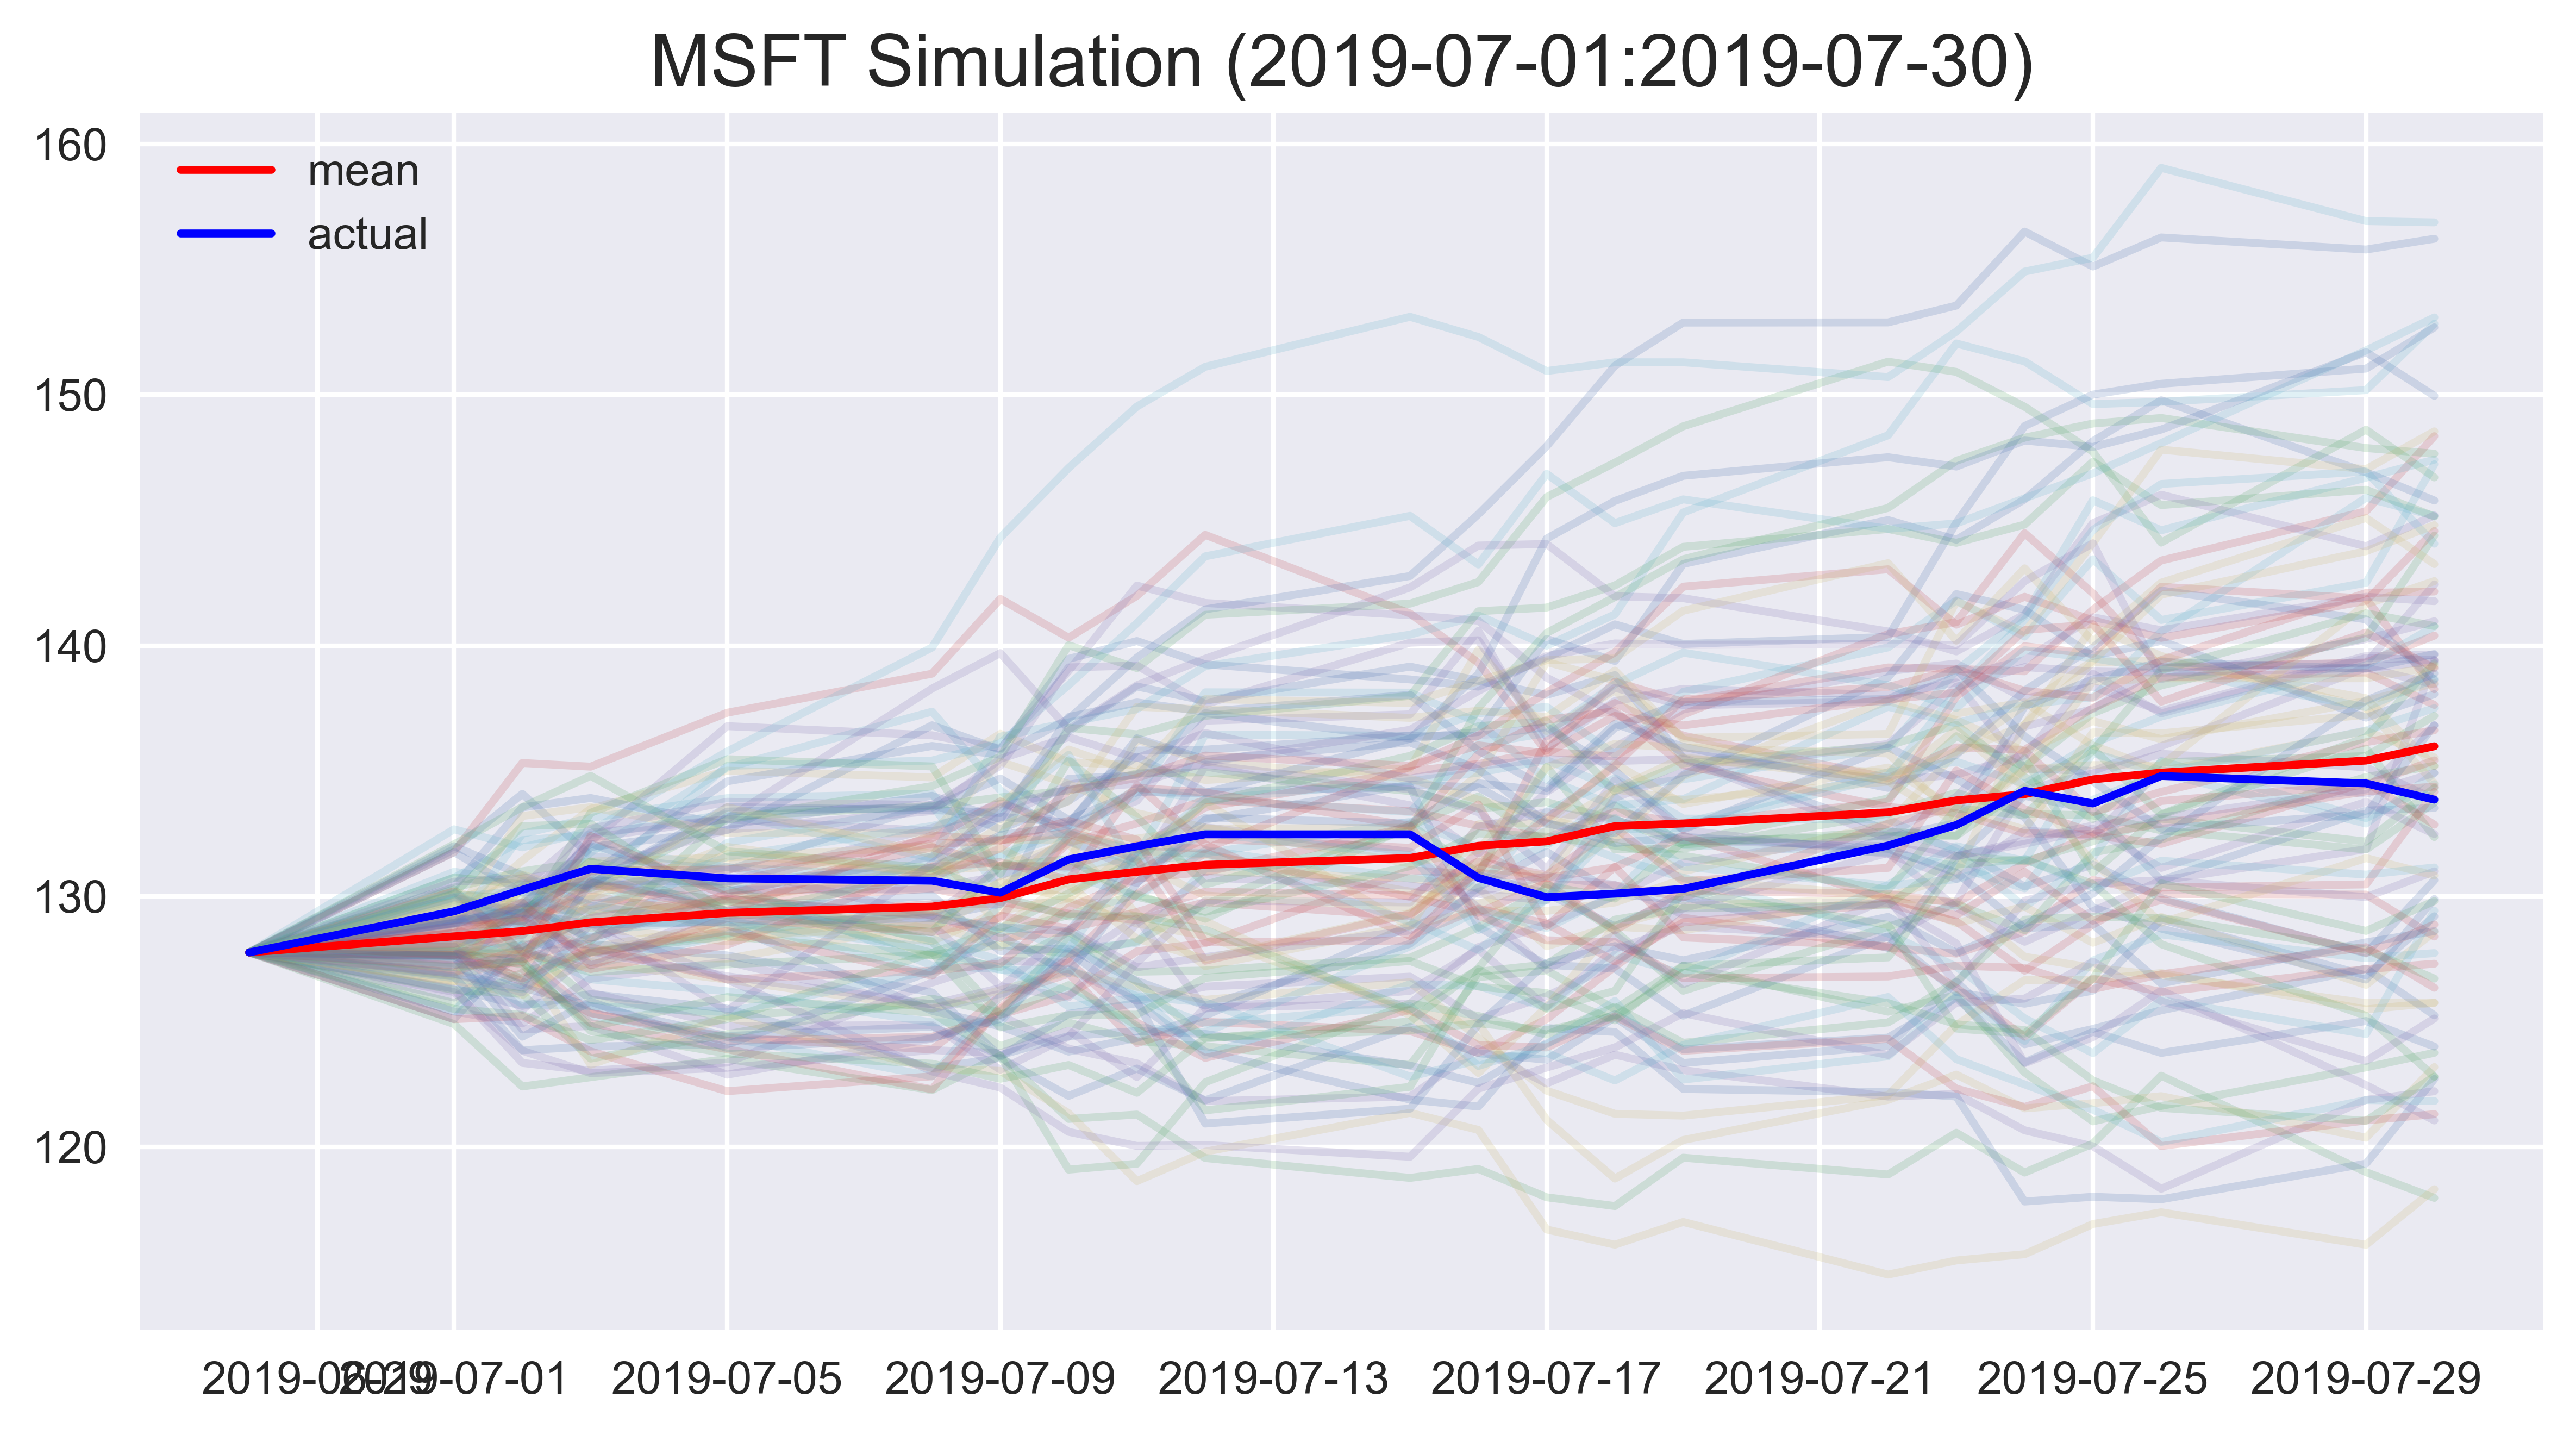

In [9]:
# Prepare objects for plotting
last_train_date = train.index[-1].date()
first_test_date = test.index[0].date()
last_test_date = test.index[-1].date()
plot_title = f'{RISKY_ASSET} Simulation ({first_test_date}:{last_test_date})'

selected_indices = adj_close[last_train_date:last_test_date].index
index = [date.date() for date in selected_indices]

gbm_simulations_df = pd.DataFrame(np.transpose(gbm_simulations), index=index)

# Plotting
ax = gbm_simulations_df.plot(alpha=0.2, legend=False)
line_1, = ax.plot(index, gbm_simulations_df.mean(axis=1), color='red')
line_2, = ax.plot(index, adj_close[last_train_date:last_test_date], color='blue')

# Set plot title and legend
ax.set_title(plot_title, fontsize=16)
ax.legend((line_1, line_2), ('mean', 'actual'))

# Adjust layout and show plot
plt.tight_layout()
plt.show()

### There's more 

In [10]:
%timeit gbm_simulations = simulate_gbm(s_0, mu, sigma, N_SIM, T, N)

374 µs ± 41.9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [11]:
def simulate_gbm(s_0, mu, sigma, n_sims, T, N, random_seed=42, antithetic_var=False):
    '''
    Function used for simulating stock returns using Geometric Brownian Motion.
    
    Parameters
    ------------
    s_0 : float
    Initial stock price
    mu : float
    Drift coefficient
    sigma : float
    Diffusion coefficient
    n_sims : int
    Number of simulations paths
    dt : float
    Time increment, most commonly a day
    T : float
    Length of the forecast horizon, same unit as dt
    N : int
    Number of time increments in the forecast horizon
    random_seed : int
    Random seed for reproducibility
    antithetic_var : bool
    Boolean whether to use antithetic variates approach to reduce variance
    
    Returns
    -----------
    S_t : np.ndarray
    Matrix (size: n_sims x (T+1)) containing the simulation results. 
    Rows respresent sample paths, while columns point of time.
    '''''
    
    np.random.seed(random_seed)
        
    # time increment
    dt = T/N
        
    # Brownian
    if antithetic_var:
        dW_ant = np.random.normal(scale = np.sqrt(dt), 
                                     size=(int(n_sims/2), N + 1))
        dW = np.concatenate((dW_ant, -dW_ant), axis=0)
    else: 
        dW = np.random.normal(scale = np.sqrt(dt), 
                                     size=(n_sims, N + 1))
                
    # simulate the evolution of the process
    S_t = s_0 * np.exp(np.cumsum((mu - 0.5 * sigma ** 2) * dt + sigma * dW, 
                                            axis=1)) 
    S_t[:, 0] = s_0
                
    return S_t

In [12]:
%timeit gbm_simulations = simulate_gbm(s_0, mu, sigma, N_SIM, T, N)

205 µs ± 19.2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [13]:
%timeit gbm_simulations = simulate_gbm(s_0, mu, sigma, N_SIM, T, N, antithetic_var=True)

178 µs ± 16.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


## Pricing European Options using Simulations 

2. Define the parameters for the valuation:

In [14]:
S_0 = 100
K = 100
r = 0.05
sigma = 0.50
T = 1 # 1 year
N = 252 # 252 days in a year
dt = T / N # time step
N_SIMS = 100000 # number of simulations
discount_factor = np.exp(-r * T)

3. Define the function using the analytical solution:

In [15]:
def black_scholes_analytical(S_0, K, T, r, sigma, option_type='call'):
    '''
    Function for calculating the price of European options using the analytical form of the Black-Scholes model.
    
    Parameters
    ----------
    S_0 : float
        Initial stock price.
    K : float
        Strike price.
    T : float
        Time to maturity in years.
    r : float
        Annualized risk-free rate.
    sigma : float
        Standard deviation of the stock returns.
    option_type : str
        Type of the option. Allowable values: ['call', 'put'].
    
    Returns
    -------
    option_premium : float
        The premium on the option calculated using the Black-Scholes model.
    '''
    
    # Calculate d1 and d2
    d1 = (np.log(S_0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    # Calculate option premium
    if option_type == 'call':
        val = S_0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        val = K * np.exp(-r * T) * norm.cdf(-d2) - S_0 * norm.cdf(-d1)
    else:
        raise ValueError("Invalid option type. Allowed values are 'call' or 'put'.")
    
    return val

4. Valuate the call option using the specified parameters:

In [16]:
black_scholes_analytical(S_0=S_0, K=K, T=T, r=r, sigma=sigma)

21.79260421286685

5. Simulate the stock path using GBM:

In [17]:
gbm_sims = simulate_gbm(s_0=S_0, mu=r, sigma=sigma, 
                       n_sims=N_SIMS, T=T, N=N)

6. Calculate the option premium:

In [18]:
premium = discount_factor * np.mean(np.maximum(0, gbm_sims[:, -1] - K))
premium

21.63279839570765

## Pricing American Options with Least Squares Monte Carlo

2. Define the parameters:

In [19]:
# Define the parameters
S_0 = 36
K = 40
r = 0.06
sigma = 0.2
T = 1  # 1 year
N = 50 
dt = T / N 
N_SIMS = 10**5 
discount_factor = np.exp(-r * dt)
OPTION_TYPE = 'put'
POLY_DEGREE = 5

# Simulate the stock prices using GBM
gbm_sims = simulate_gbm(s_0=S_0, mu=r, sigma=sigma, n_sims=N_SIMS, T=T, N=N)

# Calculate the payoff matrix
payoff_matrix = np.maximum(K - gbm_sims, 0)  # American put option payoff

# Define the value matrix and fill in the last column (time T)
value_matrix = np.zeros_like(payoff_matrix)
value_matrix[:, -1] = payoff_matrix[:, -1]

# Iteratively calculate the continuation value and the value vector at each time step
for t in range(N - 1, 0, -1):
    # Fit a polynomial to the continuation values
    regression = np.polyfit(gbm_sims[:, t], value_matrix[:, t + 1] * discount_factor, POLY_DEGREE)
    continuation_value = np.polyval(regression, gbm_sims[:, t])
    
    # Update the value matrix with the optimal decision
    value_matrix[:, t] = np.where(
        payoff_matrix[:, t] > continuation_value,
        payoff_matrix[:, t],
        value_matrix[:, t + 1] * discount_factor
    )

7. Calculate the option premium:

In [20]:
option_premium = np.mean(value_matrix[:, 1] * discount_factor)
print(f'The premium on the specified American {OPTION_TYPE} option is {option_premium:.3f}')

The premium on the specified American put option is 4.465


8. Calculate the premium of a European put with the same parameters:

In [22]:
black_scholes_analytical(S_0=S_0, K=K, T=T, r=r, sigma=sigma)

2.1737264482268923

9. As an extra check, calculate the prices of the American and European call options:

In [23]:
# Black-Scholes analytical function for European options
def black_scholes_analytical(S_0, K, T, r, sigma, option_type='call'):
    d1 = (np.log(S_0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type == 'call':
        val = S_0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        val = K * np.exp(-r * T) * norm.cdf(-d2) - S_0 * norm.cdf(-d1)
    else:
        raise ValueError("Invalid option type. Allowed values are 'call' or 'put'.")
    
    return val

In [24]:
# Simulate GBM function
def simulate_gbm(s_0, mu, sigma, n_sims, T, N, random_seed=42):
    np.random.seed(random_seed)
    dt = T / N
    dW = np.random.normal(scale=np.sqrt(dt), size=(n_sims, N))
    W = np.cumsum(dW, axis=1)
    time_step = np.linspace(dt, T, N)
    time_steps = np.broadcast_to(time_step, (n_sims, N))
    S_t = s_0 * np.exp((mu - 0.5 * sigma**2) * time_steps + sigma * W)
    S_t = np.insert(S_t, 0, s_0, axis=1)
    return S_t

In [25]:
# LSMC for American option pricing
def lsmc_american_option(S_0, K, T, N, r, sigma, n_sims, option_type='call', poly_degree=5):
    discount_factor = np.exp(-r * (T / N))
    gbm_sims = simulate_gbm(S_0, r, sigma, n_sims, T, N)
    
    if option_type == 'call':
        payoff_matrix = np.maximum(gbm_sims - K, 0)
    elif option_type == 'put':
        payoff_matrix = np.maximum(K - gbm_sims, 0)
    else:
        raise ValueError("Invalid option type. Allowed values are 'call' or 'put'.")
    
    value_matrix = np.zeros_like(payoff_matrix)
    value_matrix[:, -1] = payoff_matrix[:, -1]
    
    for t in range(N - 1, 0, -1):
        regression = np.polyfit(gbm_sims[:, t], value_matrix[:, t + 1] * discount_factor, poly_degree)
        continuation_value = np.polyval(regression, gbm_sims[:, t])
        value_matrix[:, t] = np.where(payoff_matrix[:, t] > continuation_value, payoff_matrix[:, t], 
                                                          value_matrix[:, t + 1] * discount_factor)
    
    option_price = value_matrix[:, 1].mean() * discount_factor
    return option_price

In [26]:
# Calculate European call price using Black-Scholes
european_call_price = black_scholes_analytical(S_0=S_0, K=K, T=T, r=r, sigma=sigma)

# Calculate American call price using LSMC
american_call_price = lsmc_american_option(S_0=S_0, K=K, T=T, N=N, r=r, sigma=sigma, n_sims=N_SIMS, 
                                           option_type='call', poly_degree=POLY_DEGREE)

# Print results
print(f"The price of the European call is {european_call_price:.3f}, and the American call's price (using {N_SIMS} simulations) is {american_call_price:.3f}")

The price of the European call is 2.174, and the American call's price (using 100000 simulations) is 2.060


## Pricing American Options using Quantlib

In [27]:
# Define the parameters
S_0 = 36
r_rate = 0.06
sigma_vol = 0.2
K = 40
OPTION_TYPE = 'put'
POLY_DEGREE = 5 
R_SEED = 42
N_SIMS = 10**5 
N = 50

# Specify the calendar and the day counting convention
calendar = ql.UnitedStates(ql.UnitedStates.NYSE)
day_counter = ql.ActualActual(ql.ActualActual.ISDA)

# Specify the valuation date and the expiry date of the option
valuation_date = ql.Date(1, 1, 2018)
expiry_date =  ql.Date(1, 1, 2019)
ql.Settings.instance().evaluationDate = valuation_date

# Define the option type (call/put), type of exercise and the payoff
if OPTION_TYPE == 'call':
    option_type_ql = ql.Option.Call
elif OPTION_TYPE == 'put':
    option_type_ql = ql.Option.Put

exercise = ql.AmericanExercise(valuation_date, expiry_date)
payoff = ql.PlainVanillaPayoff(option_type_ql, K)

# Prepare the market-related data
u = ql.SimpleQuote(S_0)
r = ql.SimpleQuote(r_rate)
sigma = ql.SimpleQuote(sigma_vol)

# Create the term structures
risk_free_rate = ql.FlatForward(valuation_date, ql.QuoteHandle(r), day_counter)
volatility = ql.BlackConstantVol(valuation_date, calendar, ql.QuoteHandle(sigma), day_counter)
dividend_yield = ql.FlatForward(valuation_date, ql.QuoteHandle(ql.SimpleQuote(0)), day_counter)

# Create the Black-Scholes process
bsm_process = ql.BlackScholesMertonProcess(ql.QuoteHandle(u), 
                                           ql.YieldTermStructureHandle(dividend_yield), 
                                           ql.YieldTermStructureHandle(risk_free_rate), 
                                           ql.BlackVolTermStructureHandle(volatility))

# Define the American option
american_option = ql.VanillaOption(payoff, exercise)

# Pricing the American option using the BinomialVanillaEngine
engine = ql.BinomialVanillaEngine(bsm_process, "crr", 1000)  # 'crr' is for Cox-Ross-Rubinstein
american_option.setPricingEngine(engine)

# Calculate the price
american_option_price = american_option.NPV()
print(f"The price of the American {OPTION_TYPE} option is {american_option_price:.2f}")

The price of the American put option is 4.49


6. Specify the market-related curves:

In [28]:
# Create the term structures
underlying = ql.QuoteHandle(u)
volatility = ql.BlackConstantVol(0, ql.TARGET(), ql.QuoteHandle(sigma), day_counter)
risk_free_rate = ql.FlatForward(0, ql.TARGET(), ql.QuoteHandle(r), day_counter)

# Plug in the market-related data into the BS process
bs_process = ql.BlackScholesProcess(
    underlying,
    ql.YieldTermStructureHandle(risk_free_rate),
    ql.BlackVolTermStructureHandle(volatility)
)

# Instantiate the Monte Carlo engine for the American options
engine = ql.MCAmericanEngine(
    bs_process, 'PseudoRandom', timeSteps=N, 
    polynomOrder=POLY_DEGREE, 
    seedCalibration=R_SEED, 
    requiredSamples=N_SIMS
)

# Instantiate the option object and set its pricing engine
option = ql.VanillaOption(payoff, exercise)
option.setPricingEngine(engine)

# Calculate the option premium
option_premium_ql = option.NPV()

# Print the value
print(f'The value of the American {OPTION_TYPE} option is: {option_premium_ql:.3f}')

The value of the American put option is: 4.456


## Estimating Value-at-risk using Monte Carlo

In [29]:
# set random seed for reproducibility
np.random.seed(42)

# Define the parameters that will be used for this exercise:
RISKY_ASSETS = ['GOOG', 'META']
SHARES = [5, 5]
START_DATE = '2018-01-01'
END_DATE = '2018-12-31'
T = 1
N_SIMS = 10 ** 5

# Download data from Yahoo Finance:
df = yf.download(RISKY_ASSETS, start=START_DATE, 
                end=END_DATE)
print(f'Downloaded {df.shape[0]} rows of data.')

[*********************100%%**********************]  2 of 2 completed

Downloaded 250 rows of data.


In [30]:
df.head()

Price       Adj Close                  Close                   High  \
Ticker           GOOG        META       GOOG        META       GOOG   
Date                                                                  
2018-01-02  53.250000  181.227707  53.250000  181.419998  53.347000   
2018-01-03  54.124001  184.474274  54.124001  184.669998  54.314499   
2018-01-04  54.320000  184.134628  54.320000  184.330002  54.678501   
2018-01-05  55.111500  186.651962  55.111500  186.850006  55.212502   
2018-01-08  55.347000  188.080444  55.347000  188.279999  55.563499   

Price                         Low                   Open              \
Ticker            META       GOOG        META       GOOG        META   
Date                                                                   
2018-01-02  181.580002  52.261501  177.550003  52.417000  177.679993   
2018-01-03  184.779999  53.160500  181.330002  53.215500  181.880005   
2018-01-04  186.210007  54.200100  184.100006  54.400002  184.899994   
2018-01-05  186.899994  54.599998  184.929993  54.700001  185.589996   
2018-01-08  188.899994  55.081001  186.330002  55.111500  187.199997   

Price         Volume            
Ticker          GOOG      META  
Date                            
2018-01-02  24752000  18151900  
2018-01-03  28604000  16886600  
2018-01-04  20092000  13880900  
2018-01-05  25582000  13574500  
2018-01-08  20952000  17994700

4. Calculate daily returns:

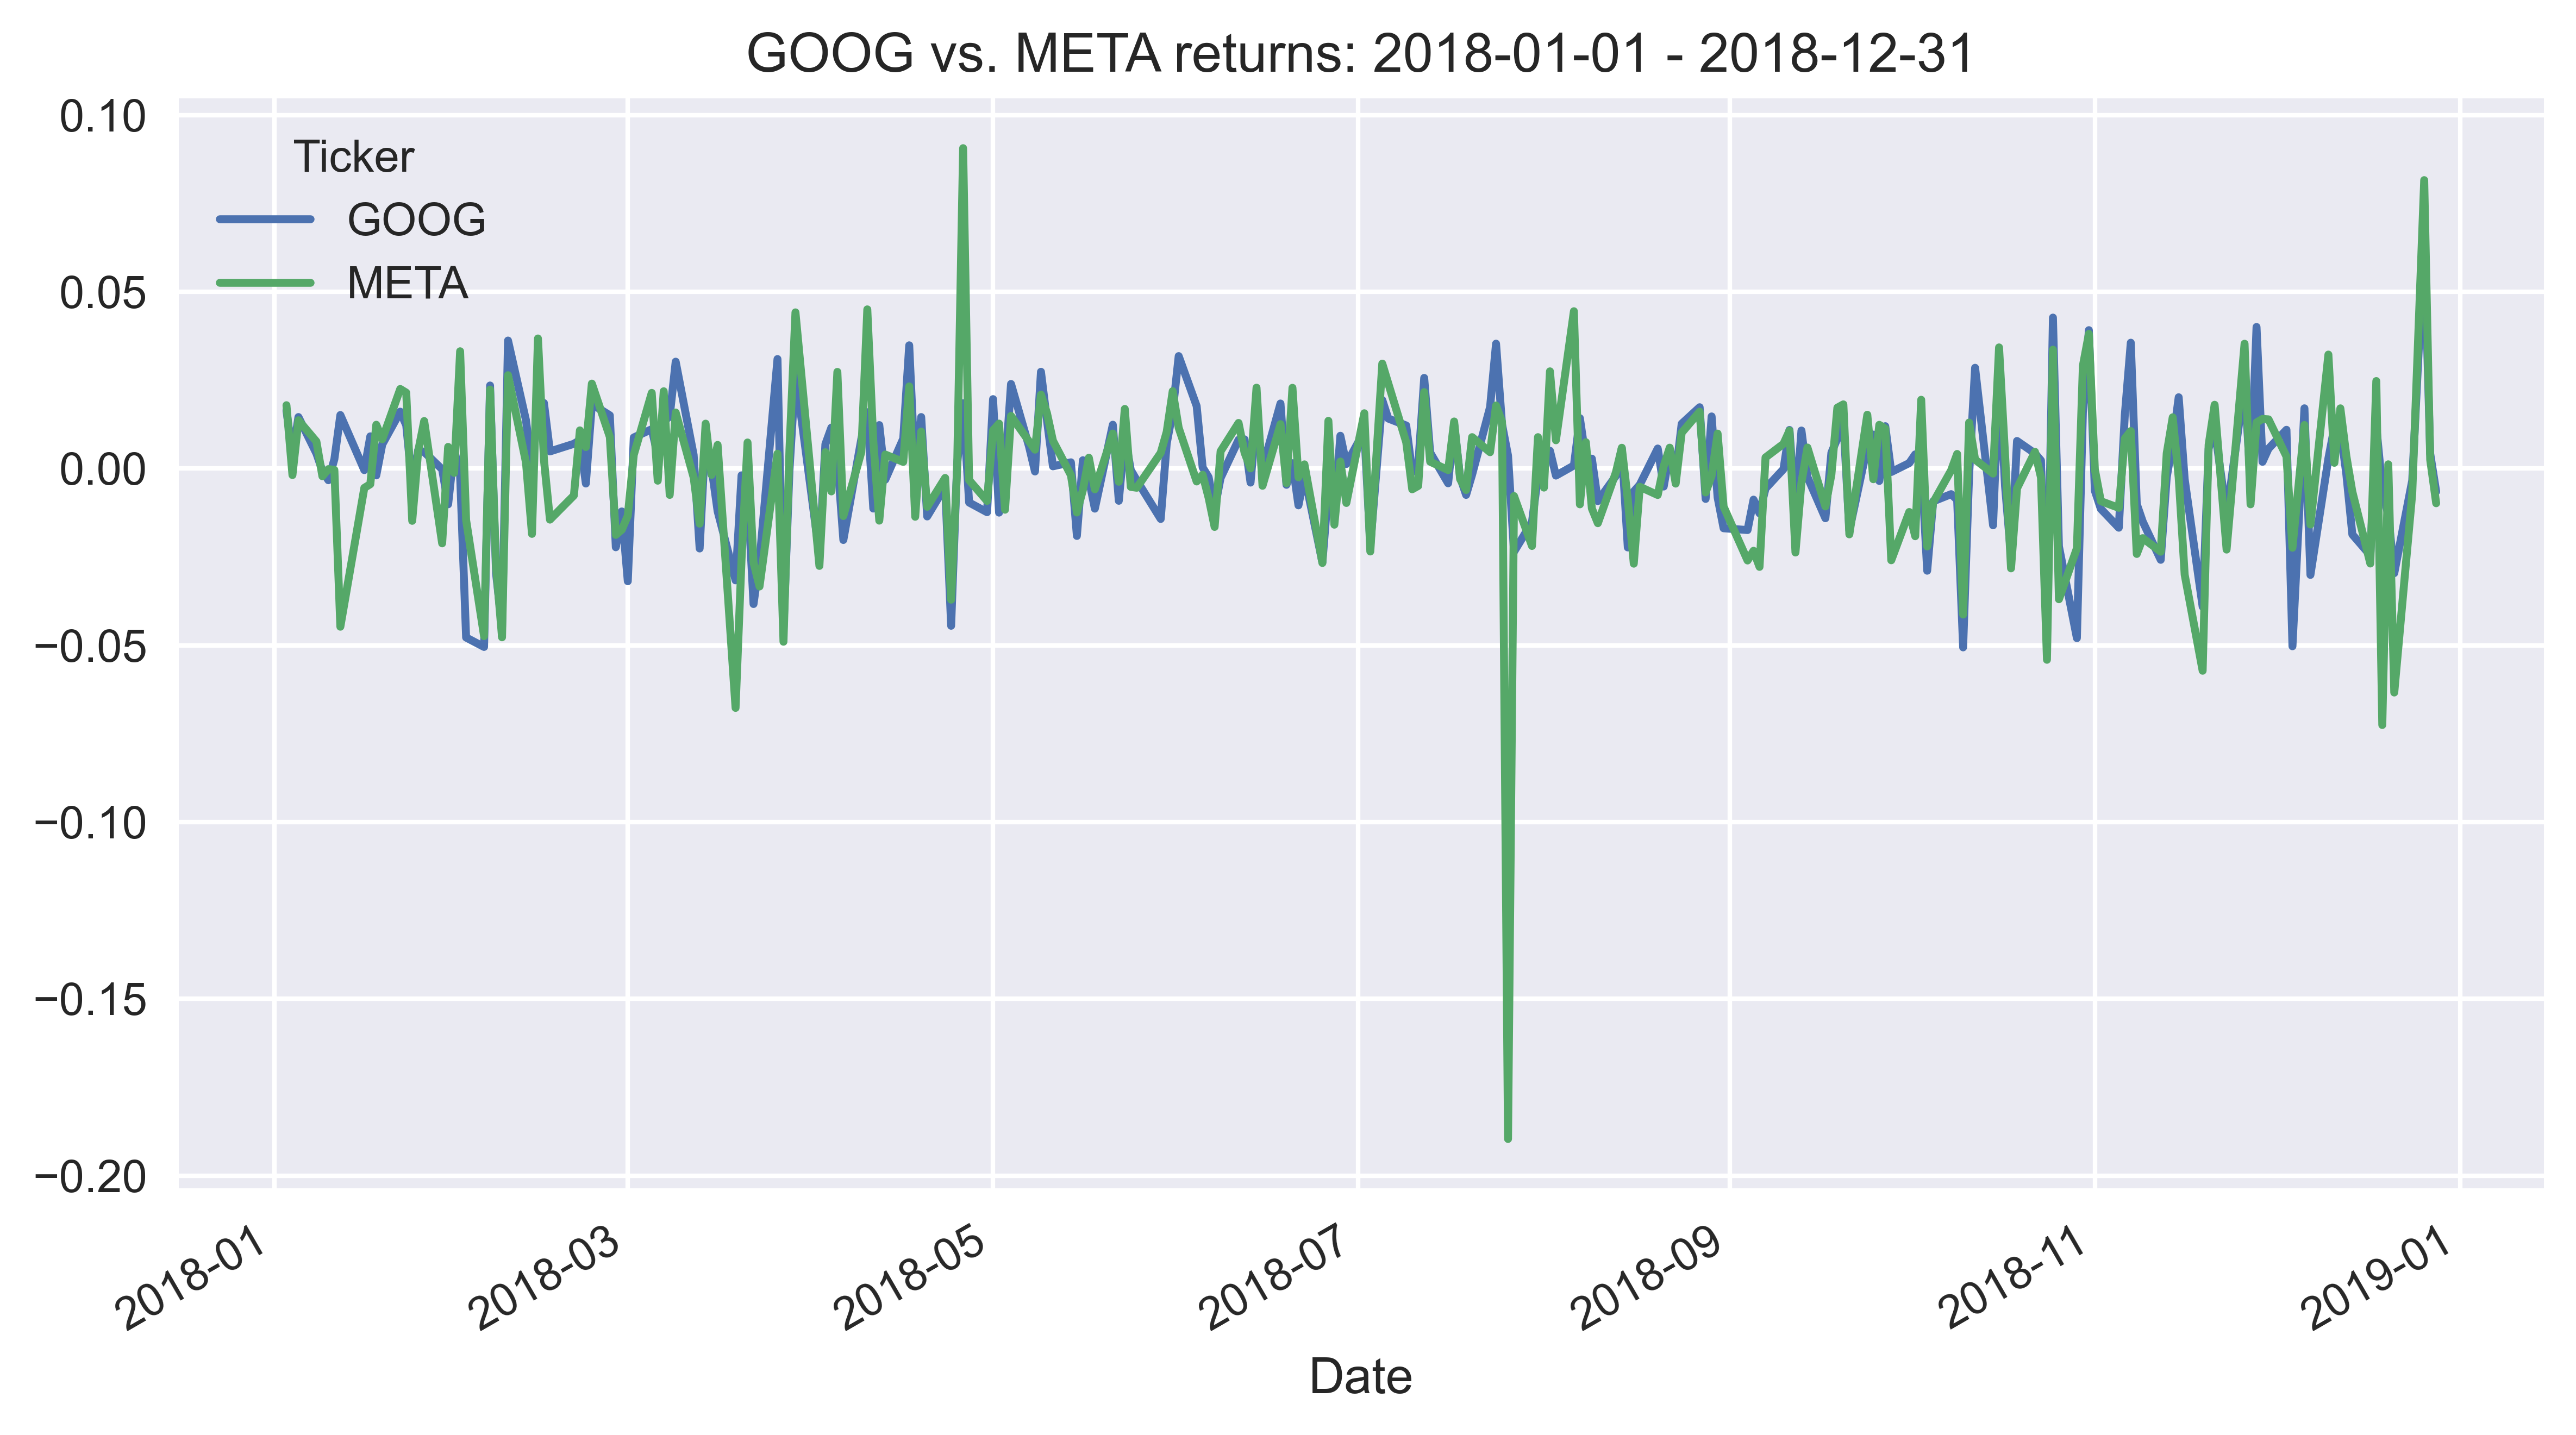

Correlation between returns: 0.62


In [31]:
adj_close = df['Adj Close']
returns = adj_close.pct_change().dropna()
plot_title = f'{" vs. ".join(RISKY_ASSETS)} returns: {START_DATE} - {END_DATE}'
returns.plot(title=plot_title)

plt.tight_layout()
plt.show()

print(f'Correlation between returns: {returns.corr().values[0,1]:.2f}')

5. Calculate the covariance matrix:

In [32]:
cov_mat = returns.cov()
cov_mat

Ticker      GOOG      META
Ticker                    
GOOG    0.000315  0.000265
META    0.000265  0.000575

6. Perform the Cholesky decomposition of the covariance matrix:

In [33]:
chol_mat = np.linalg.cholesky(cov_mat)
chol_mat

array([[0.0177591 , 0.        ],
       [0.0149283 , 0.01876435]])

7. Draw correlated random numbers from Standard Normal distribution:

In [34]:
# Draw correlated random numbers from Standard Normal distribution:

rv = np.random.normal(size=(N_SIMS, len(RISKY_ASSETS)))
correlated_rv = np.transpose(np.matmul(chol_mat, np.transpose(rv)))

# Define metrics used for simulations:

r = np.mean(returns, axis=0).values
sigma = np.std(returns, axis=0).values
S_0 = adj_close.values[-1, :]
P_0 = np.sum(SHARES * S_0)

# Calculate the terminal price of the considered stocks:
S_T = S_0 * np.exp((r - 0.5 * sigma ** 2) * T + 
                  sigma * np.sqrt(T) * correlated_rv)

# Calculate the terminal portfolio value and calculate the portfolio returns:
P_T = np.sum(SHARES * S_T, axis=1)
P_diff = P_T - P_0

# Calculate VaR:
P_diff_sorted = np.sort(P_diff)
percentiles = [0.01, 0.1, 1.]
var = np.percentile(P_diff_sorted, percentiles)

for x, y in zip(percentiles, var):
    print(f'1-day VaR with {100-x}% confidence: {-y:.2f}$')

1-day VaR with 99.99% confidence: 2.43$
1-day VaR with 99.9% confidence: 2.18$
1-day VaR with 99.0% confidence: 1.86$


12. Present the results on a graph:

C:\Users\USER\AppData\Local\Temp\ipykernel_11960\435473287.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(P_diff, kde=False)


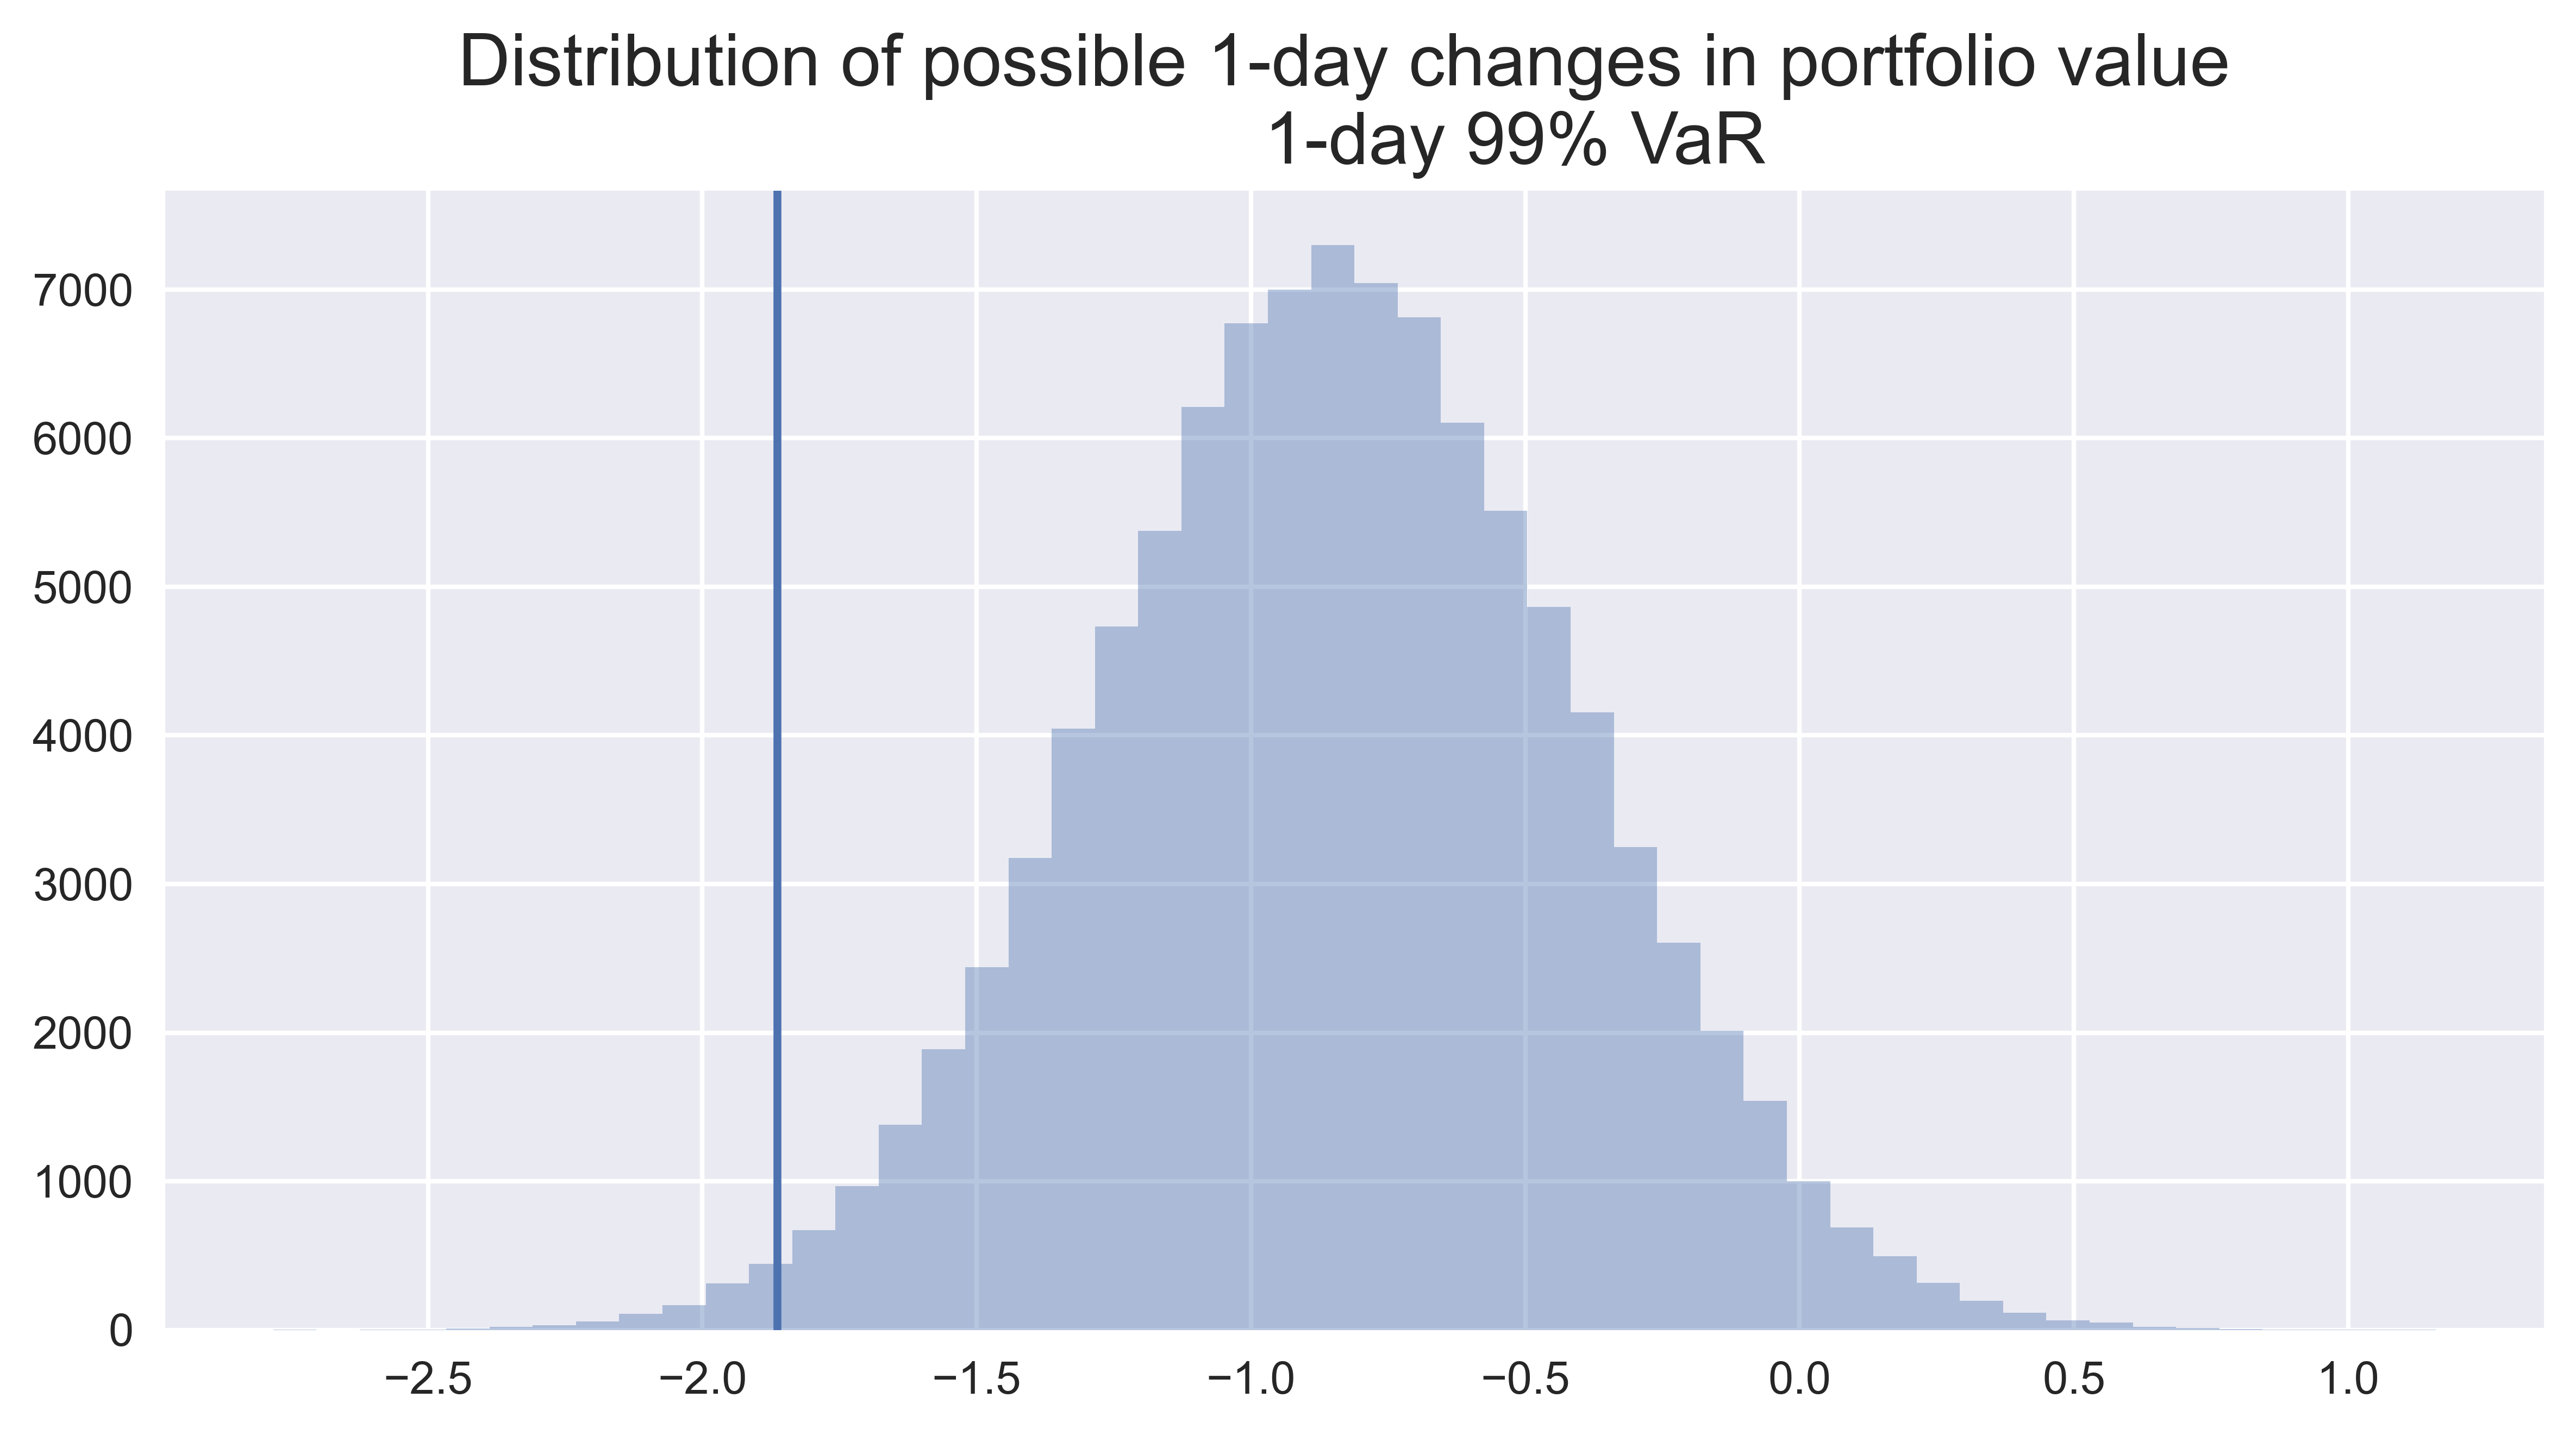

In [35]:
ax = sns.distplot(P_diff, kde=False)
ax.set_title('''Distribution of possible 1-day changes in portfolio value 
                1-day 99% VaR''''', fontsize=16)
ax.axvline(var[2], 0, 10000)

plt.tight_layout();
plt.show();